# Guess Core and use other methods to interpolate

In [48]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate, guess
import numpy as np
import matplotlib.pyplot as plt
from BlockMatrix import BlockMatrix


In [17]:
with open('../c5h4n2o2/models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('../c5h4n2o2/models/train_data.pkl', 'rb') as f:
    train = pickle.load(f) # fock, overlap, file, density
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])
mat_dim = train_X[0].shape[0]
mat_dim


49

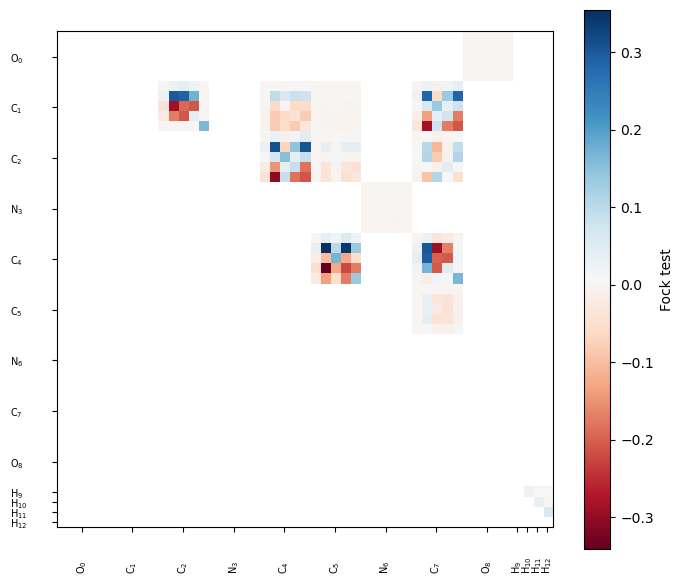

np.float64(49.0)

In [18]:
mol = load(train_files[10], Backend.PY).native
dm = BlockMatrix(mol, train_X[10]) # can also override the matrix
dm.plot_blocks_by_type("homo", labels="atoms", figsize=(8, 7), title="Fock test", imshow_args={"cmap": "RdBu"})
dm.Matrix.trace()

## 1) First Trial
Just learn the Fock center Block-matrix for the general Case for all given elements! 

In [19]:
elements = ["C", "N", "O", "H"]
training_centers_X = {"C":[], "N":[], "O":[], "H":[]}
training_centers_y = {"C":[], "N":[], "O":[], "H":[]}
test_centers_X = {"C":[], "N":[], "O":[], "H":[]}
test_centers_y = {"C":[], "N":[], "O":[], "H":[]}

for fock, overlap, file, _ in train:
    mol = load(file, Backend.PY).native
    dmX = BlockMatrix(mol, overlap)
    dmY = BlockMatrix(mol, fock)
    for element in elements:
        for block in dmX.get_blocks_by_atom(element, block_type="center"):
            training_centers_X[element].append(block)
        for block in dmY.get_blocks_by_atom(element, block_type="center"):
            training_centers_y[element].append(block)

for fock, overlap, file, _ in test:
    mol = load(file, Backend.PY).native
    dmX = BlockMatrix(mol, overlap)
    dmY = BlockMatrix(mol, fock)
    for element in elements:
        for block in dmX.get_blocks_by_atom(element, block_type="center"):
            test_centers_X[element].append(block)
        for block in dmY.get_blocks_by_atom(element, block_type="center"):
            test_centers_y[element].append(block)


True

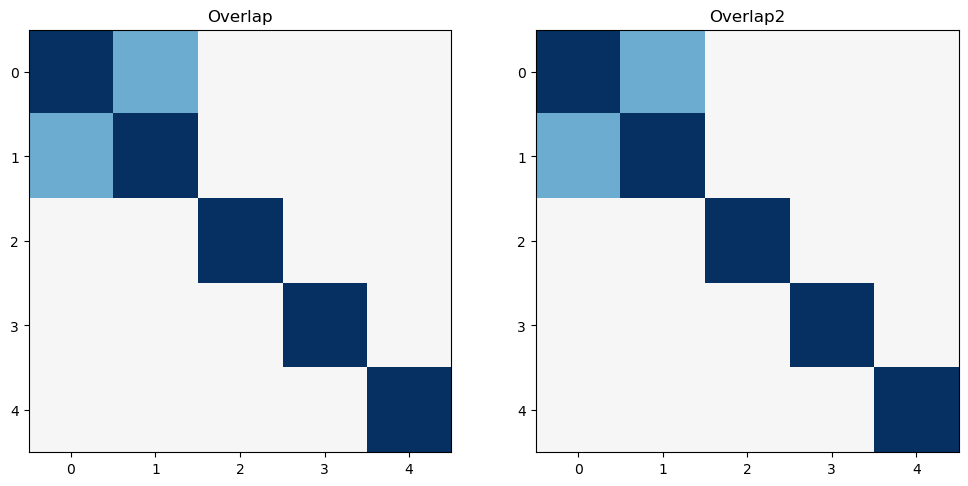

In [20]:
c_s = training_centers_X["C"]
for i in range(len(c_s)):
    diff = c_s[0] - c_s[i]
    if diff.sum() != 0: 
        print("Not equal")
# it seems that everything in sto-3g is actually the same
mol1 = load(train_files[0], Backend.PY).native
mol2 = load(train_files[1], Backend.PY).native
center1 = BlockMatrix(mol1)
center2 = BlockMatrix(mol2)
mean_c_ovlp1 = np.mean(center1.get_blocks_by_atom("C", block_type="center"), axis=0)
mean_c_ovlp2 = np.mean(center2.get_blocks_by_atom("C", block_type="center"), axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mean_c_ovlp1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[0].set_title("Overlap")
ax[1].imshow(mean_c_ovlp2, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].set_title("Overlap2")
np.allclose(mean_c_ovlp1, mean_c_ovlp2)

In [21]:
# try different basis sets
ex_overlap, ex_fock, ex_density = [], [], []
mols = []
for i, file in enumerate(train_files[:5]):
    mol = load(file, Backend.PY)
    mols.append(mol)
    wf = calculate(mol, basis="6-31g", guess="minao", method="dft", functional="b3lypg")
    ex_overlap.append(wf.overlap())
    ex_fock.append(wf.fock())
    ex_density.append(wf.density())


converged SCF energy = -452.712890207528
converged SCF energy = -452.630906802164
converged SCF energy = -452.619631213146
converged SCF energy = -452.72008612798
converged SCF energy = -452.642850787732


False


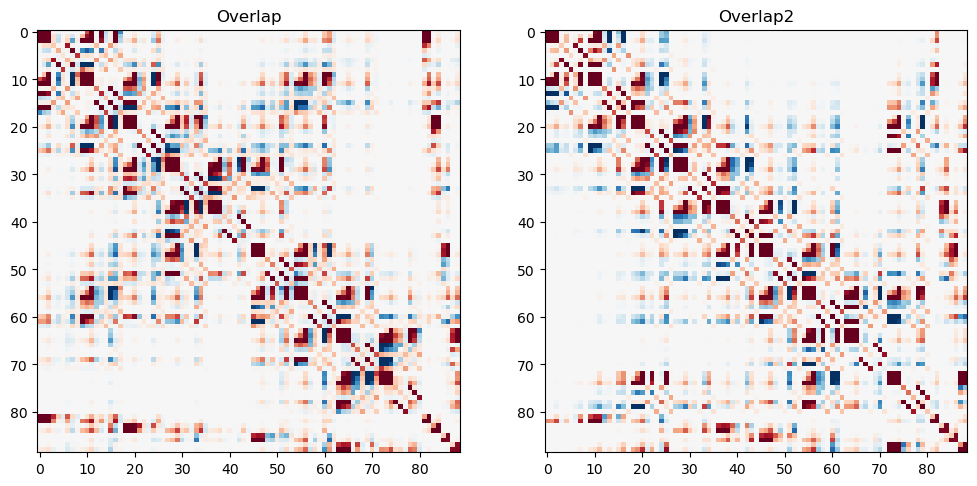

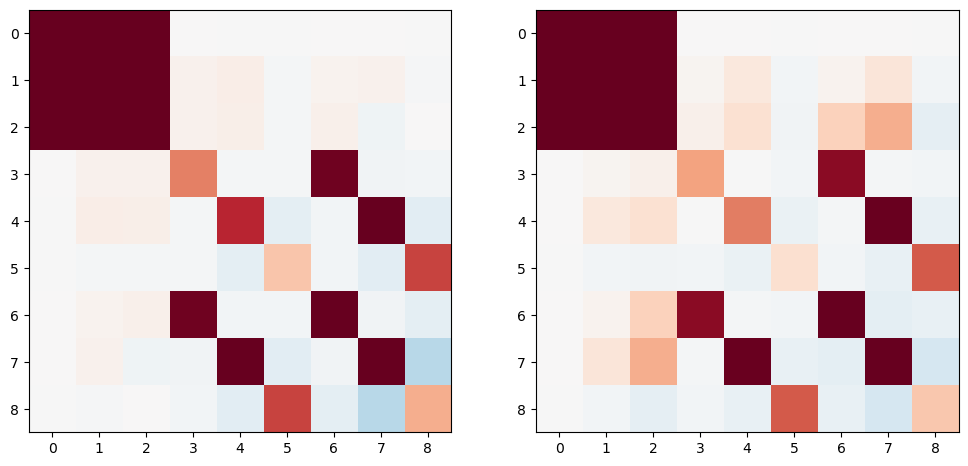

In [ ]:
ex1, ex2 = 0,3
center1 = BlockMatrix(mols[ex1].native, ex_fock[ex1].numpy)
center2 = BlockMatrix(mols[ex2].native, ex_fock[ex2].numpy)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(center1.Matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[0].set_title("Overlap")
ax[1].imshow(center2.Matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].set_title("Overlap2")

# They are also the SAME!!! - makes sense because center block is basically coef. 
c_mean1 = np.mean(center1.get_blocks_by_atom("C", block_type="center"), axis=0)
c_mean2 = np.mean(center2.get_blocks_by_atom("C", block_type="center"), axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(c_mean1, cmap="RdBu", vmin=-0.5, vmax=0.5)
# ax[0].set_title("Overlap mean")
# ax[1].imshow(c_mean2, cmap="RdBu", vmin=-0.5, vmax=0.5)
# ax[1].set_title("Overlap2 mean")
# np.allclose(c_mean1, c_mean2)
c1 = center1.get_blocks_by_atom("C", block_type="center")[0]
c2 = center1.get_blocks_by_atom("C", block_type="center")[2]
print(np.allclose(c1, c2))
ax[0].imshow(c1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].imshow(c2, cmap="RdBu", vmin=-0.5, vmax=0.5)

### 1a) Only learn the diagonal!

In [82]:
train_overlap_X = np.array([overlap for _, overlap, _, _ in train])
test_overlap_X = np.array([overlap for _, overlap, _, _ in test])
train_fock_diag = np.array([np.diag(fock) for fock, _, _, _ in train])
test_fock_diag = np.array([np.diag(fock) for fock, _, _, _ in test])
test_fock_full = np.array([fock for fock, _, _, _ in test])
test_density_full = np.array([density for _, _, _, density in test])

In [24]:
import tensorflow as tf
from tensorflow import keras
import pickle, os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sys.path.append("..")
from utils import plot_mat_comp, flatten_triang, unflatten_triang, flatten_triang_batch, unflatten_triang_batch, perform_calculation, density_from_fock, reverse_mat_permutation

2025-04-16 09:37:39.421152: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 09:37:39.430511: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 09:37:39.499404: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 09:37:39.563026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744789059.612377    1142 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744789059.62

In [28]:
train_overlap_X_flat = flatten_triang_batch(train_overlap_X)
test_overlap_X_flat = flatten_triang_batch(test_overlap_X)

# scalerX = StandardScaler()
# scalerY = StandardScaler()

train_overlap_X_flat.shape

(406, 1225)

In [29]:
train_fock_diag.shape

(406, 49)

In [74]:
flattened_dim = train_overlap_X_flat.shape[1]
diag_dim = train_fock_diag.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(diag_dim)(x)

basic_model = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])

Epoch 1/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.9829 - mae: 2.9829 - mse: 32.0795 - val_loss: 2.6981 - val_mae: 2.6981 - val_mse: 31.9856
Epoch 2/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5327 - mae: 2.5327 - mse: 25.5841 - val_loss: 2.5462 - val_mae: 2.5462 - val_mse: 29.3228
Epoch 3/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2120 - mae: 2.2120 - mse: 19.4384 - val_loss: 2.3899 - val_mae: 2.3899 - val_mse: 25.7458
Epoch 4/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7995 - mae: 1.7995 - mse: 12.0374 - val_loss: 2.1076 - val_mae: 2.1076 - val_mse: 19.9689
Epoch 5/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4227 - mae: 1.4227 - mse: 6.0829 - val_loss: 1.8299 - val_mae: 1.8299 - val_mse: 15.0026
Epoch 6/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2572 - mae: 1.2572 - mse: 4.0396 - val_loss: 1.7839 - val_mae: 1.7839 - val_mse: 14.0667
Epoch 7/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1320 - mae: 1.1320 - mse: 3.4721

Text(0.5, 1.0, 'Model loss')

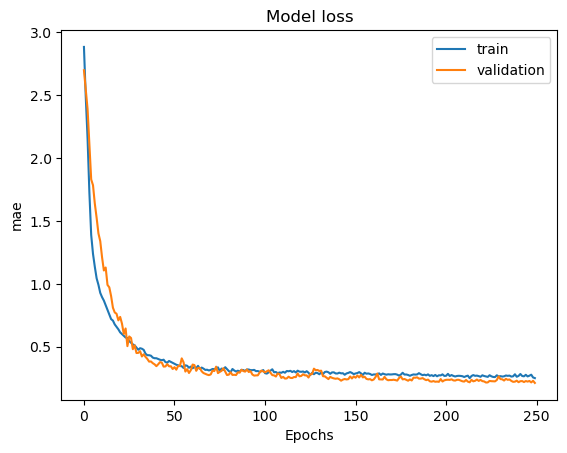

In [75]:
basic_history = basic_model.fit(train_overlap_X_flat, train_fock_diag, epochs=250, batch_size=32, validation_split=0.2, verbose=1)
plt.plot(basic_history.history['loss'], label='train')
plt.plot(basic_history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

In [88]:
test_pred_fock_diag = basic_model.predict(test_overlap_X_flat)
test_pred_fock_diag.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


(102, 49)

In [89]:
def reconstruct_Fock(diag, ovlp, K = 1.75): 
    """Take diagonal and reconstruct the Fock matrix using GWH
    """
    mat_dim = diag.shape[0]
    out = np.zeros((mat_dim, mat_dim))
    for i in range(mat_dim):
        for j in range(mat_dim):
            if i == j:
                out[i, j] = diag[i]
            else:
                out[i, j] = K * ovlp[i, j] * (diag[i] + diag[j]) / 2
    return out

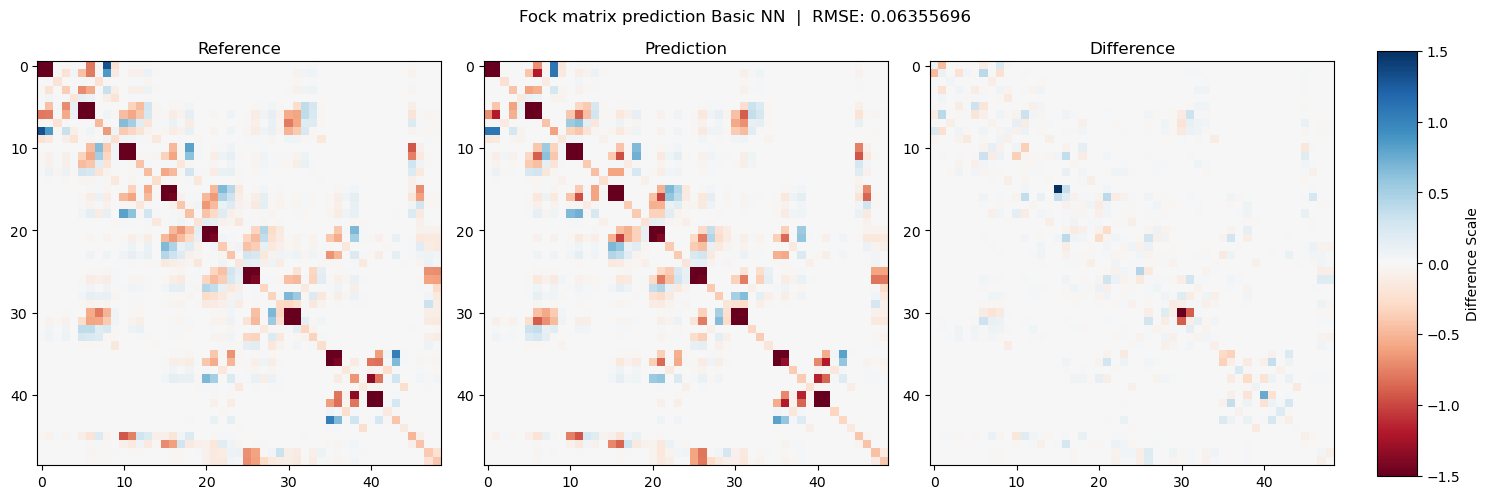

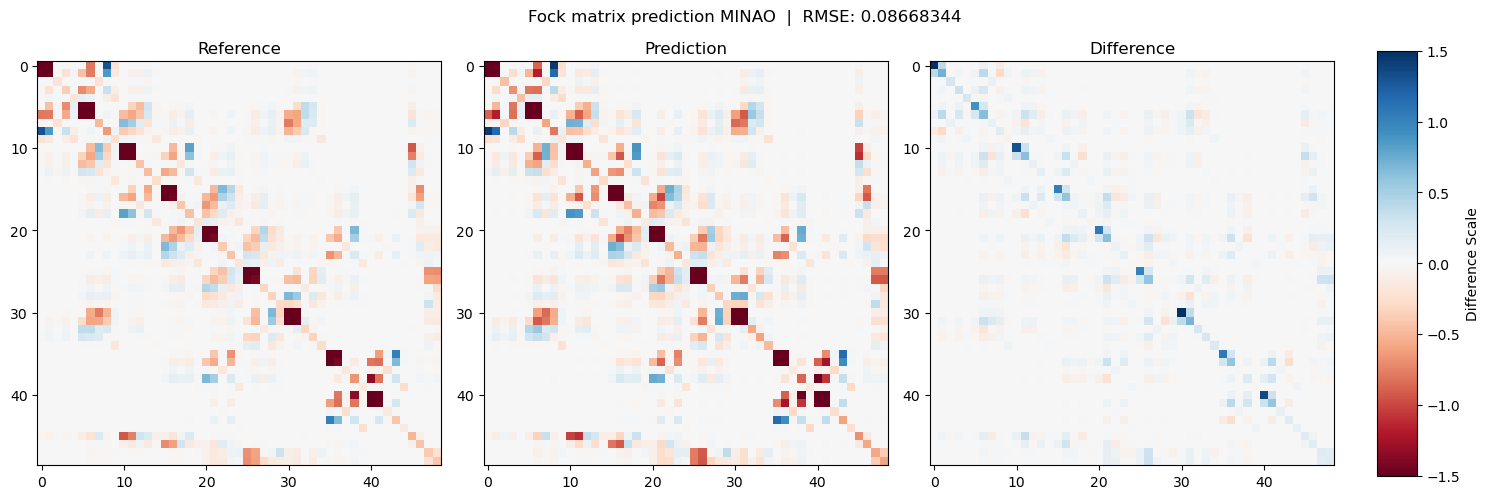

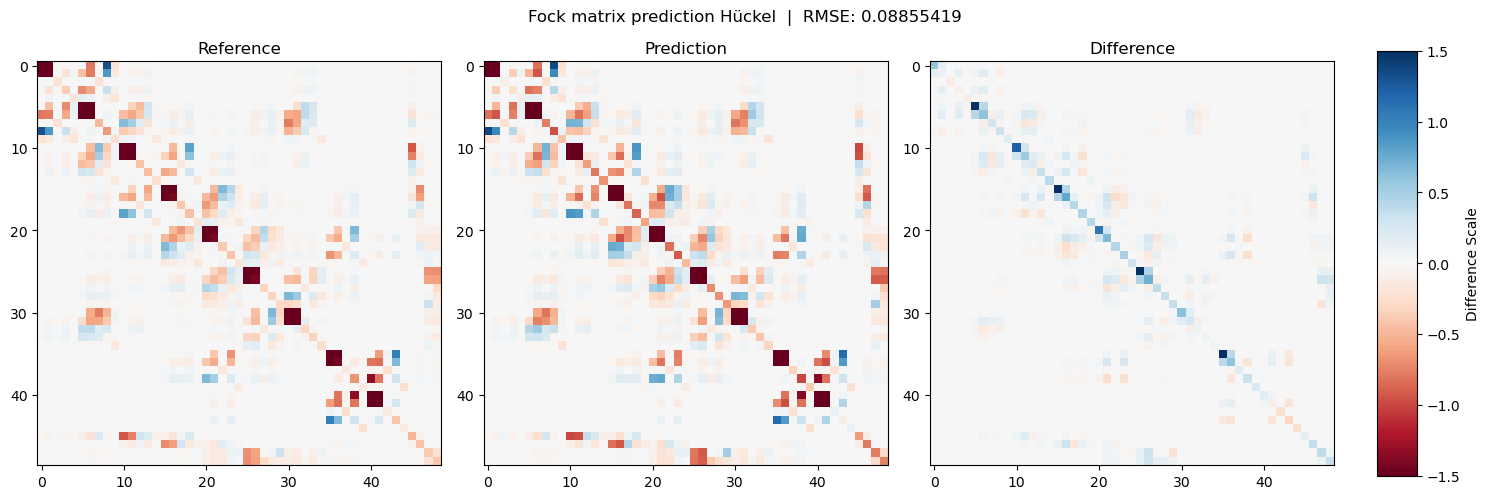

In [90]:
# example comparison: 
rand_test_sample = np.random.randint(0, len(test_pred_fock_diag))
pred_fock_example = reconstruct_Fock(test_pred_fock_diag[rand_test_sample], test_overlap_X[rand_test_sample])
ground_truth_fock_example = test_fock_full[rand_test_sample]
# compare with hückel and minao
test_mol = load(test_files[rand_test_sample], Backend.PY)
minao_guess = guess(test_mol, method="hf", basis="sto-3g", scheme="minao")
hueckel_guess = guess(test_mol, method="hf", basis="sto-3g", scheme="huckel")
plot_mat_comp(ground_truth_fock_example, pred_fock_example, title="Fock matrix prediction Basic NN")
plot_mat_comp(ground_truth_fock_example, minao_guess.fock().numpy, title="Fock matrix prediction MINAO")
plot_mat_comp(ground_truth_fock_example, hueckel_guess.fock().numpy, title="Fock matrix prediction Hückel")

Fock matrices look promising - let's check out the density matrices!

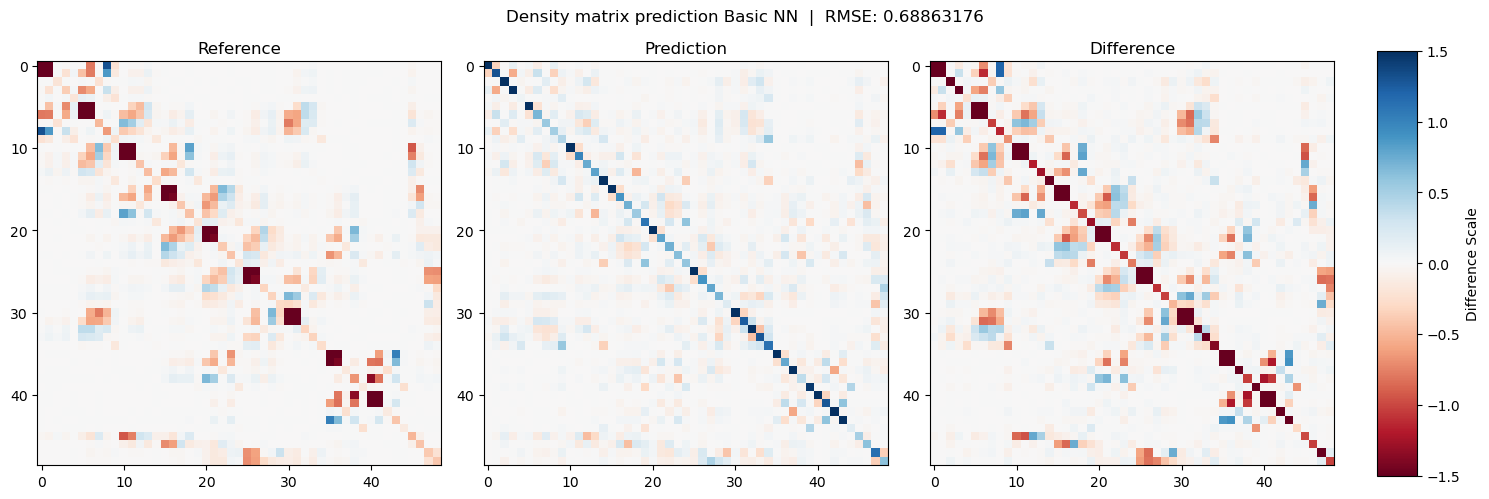

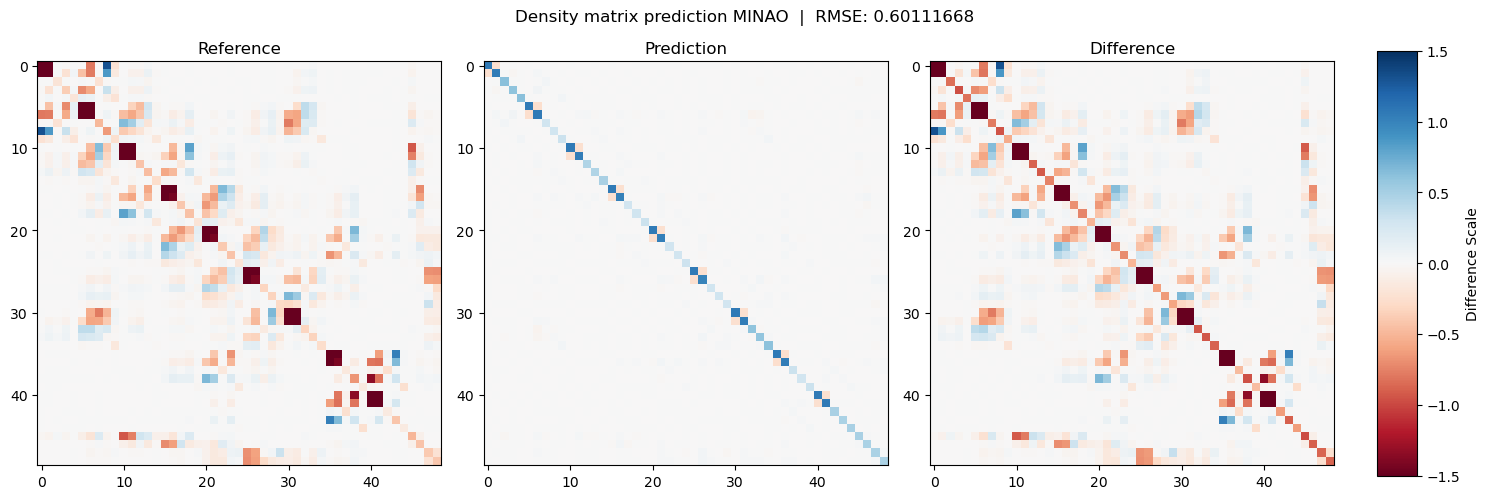

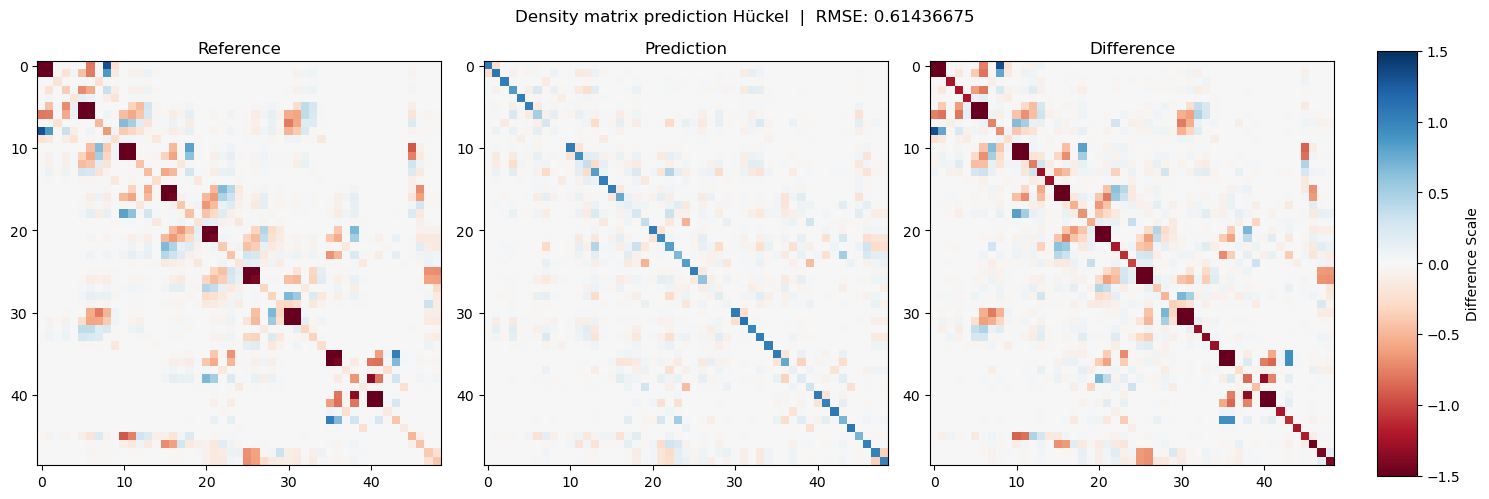

In [93]:
# Sanity check density reconstruction
ground_truth_density = test_density_full[rand_test_sample]
#ground_truth_density_reconstucted = density_from_fock(test_fock_full[rand_test_sample], test_overlap_X[rand_test_sample], 32)
#plot_mat_comp(2*ground_truth_density, ground_truth_density_reconstucted, title="Sanity check density reconstruction (Ref: 2*ref density vs. density_from_fock(ref fock, ref overlap))")


pred_density_example = density_from_fock(pred_fock_example, test_overlap_X[rand_test_sample], 32)
plot_mat_comp(ground_truth_fock_example, pred_density_example, title="Density matrix prediction Basic NN")
plot_mat_comp(ground_truth_fock_example, minao_guess.density().numpy, title="Density matrix prediction MINAO")
plot_mat_comp(ground_truth_fock_example, hueckel_guess.density().numpy, title="Density matrix prediction Hückel")

In [ ]:
# example calc
res = perform_calculation(test_files[rand_test_sample], density_guess=pred_density_example, basis_set="sto-3g", method="dft", functional="b3lypg")
print(f"NN res: {res}")
res = perform_calculation(test_files[rand_test_sample], density_guess=minao_guess.density().numpy, basis_set="sto-3g", method="dft", functional="b3lypg")
print(f"Minao res: {res}")
res = perform_calculation(test_files[rand_test_sample], density_guess=hueckel_guess.density().numpy, basis_set="sto-3g", method="dft", functional="b3lypg")
print(f"Hückel res: {res}")
res = perform_calculation(test_files[rand_test_sample], density_guess=2*ground_truth_density, basis_set="sto-3g", method="dft", functional="b3lypg")
print(f"Truth res (sanity check - should converge in 1 iteration): {res} ")


converged SCF energy = -446.917374432552
NN res: {'cycles': 17, 'conv': True, 'summary': {'nuc': np.float64(409.04589479361755), 'e1': np.float64(-1420.5043239941047), 'coul': np.float64(624.1650004085843), 'exc': np.float64(-59.623945640649595)}, 'wf': <pyscf.dft.rks.RKS object at 0x7f7198ef4250>, 'mol': <pyscf.gto.mole.Mole object at 0x7f7177e7add0>}
converged SCF energy = -446.91737443266
Minao res: {'cycles': 19, 'conv': True, 'summary': {'nuc': np.float64(409.04589479361755), 'e1': np.float64(-1420.5043400326936), 'coul': np.float64(624.1650114361204), 'exc': np.float64(-59.623940629704805)}, 'wf': <pyscf.dft.rks.RKS object at 0x7f7177f83ed0>, 'mol': <pyscf.gto.mole.Mole object at 0x7f7177cf9d90>}
converged SCF energy = -446.917374432543
Hückel res: {'cycles': 20, 'conv': True, 'summary': {'nuc': np.float64(409.04589479361755), 'e1': np.float64(-1420.504341016775), 'coul': np.float64(624.1650131247266), 'exc': np.float64(-59.62394133411233)}, 'wf': <pyscf.dft.rks.RKS object at 0x7